# Andrew Megaris: Self Driving Car Nano Degree Project 1


## Project: **Finding Lane Lines on the Road** 
***
In this project I created an image filtering process to locate and highlight the lane lines.  These images would be streamed to the filter from a front mounted camera.  I utilized OpenCV in python for this process.
---

<h1>Reflection:</h1>

**These are the 8 major steps that I apply to an image to accomplish this effect.**
* Select all yellow and white pixels from the image.
* Turn yellow and white filtered image into greyscale.
* Apply smoothing to image using a Guassina blur technique.
* Use Canny edge detection to detect where edges are located.
* Select a specific area where you actually are looking to filter.
* Apply a Hough transformation to this filtered area of interest.
* Calculate the average slope and intercept of all lines from their respective sides.
* Draw a best fit line on top of the original image.


**Imports Required**
  

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import cv2
import os, glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

%matplotlib inline

**Create a library of images and a show function**

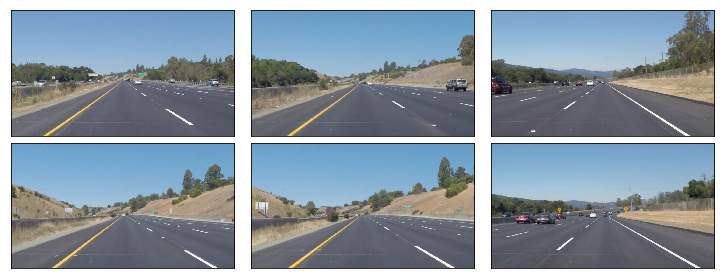

In [58]:
#reading in a directory of images and creating the image library
test_images = [mpimg.imread(path) for path in glob.glob('test_images/*.jpg')]

#printing a library of images
def show_images(images, cmap=None):
    cols = 3
    rows = len(images) + 1 // cols
    
    plt.figure(figsize=(10,11))
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image,cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
    plt.show()

show_images(test_images)

*** Frist I pull yellow and white pixels ***

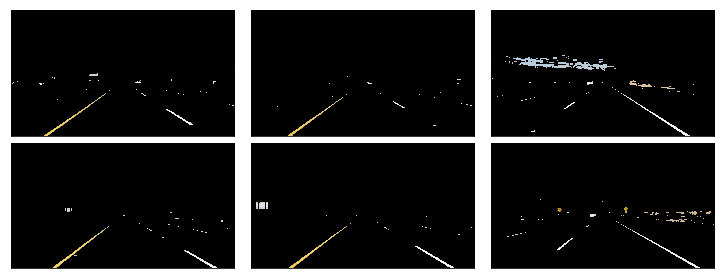

In [59]:
#convert an image to HSL color space
#this enables easier detection of white and yellow lines.
#especially lines that are under shadows.
def convert_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def pull_yellow_and_white(img):    
    #convert raw image to HSL
    converted = convert_hls(img)
    
    #define the white_mask
    lower = np.uint8([0,200,0])
    upper = np.uint8([255,255,255])
    white_mask = cv2.inRange(converted, lower, upper)
    
    #define the yellow_mask
    lower = np.uint8([10,0,100])
    upper = np.uint8([40,255,255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    
    #combine the two masks
    combined_mask = cv2.bitwise_or(yellow_mask,white_mask)
    
    return cv2.bitwise_and(img,img,mask = combined_mask)

yellow_and_white_images = []
for image in test_images:
    yellow_and_white_images.append(pull_yellow_and_white(image))

show_images(yellow_and_white_images)

**As you can see, I am able to extrapolate all of the yellow and white lane lines with only a little extra clutter. **
**Next we will grayscale what we have **

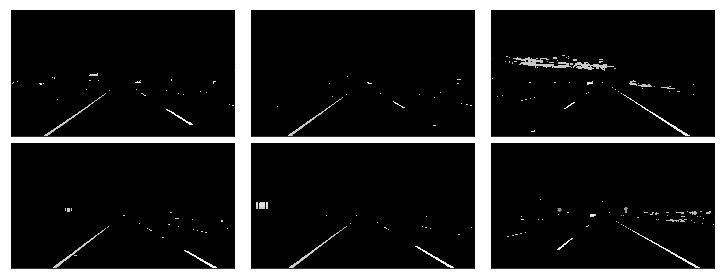

In [60]:
#Convert every pixel in the image to its respective greyscale value.
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray_images = []
for image in yellow_and_white_images:
    gray_images.append(grayscale(image))

show_images(gray_images)

**Now we can smooth our image using a Guassian Blur effect**

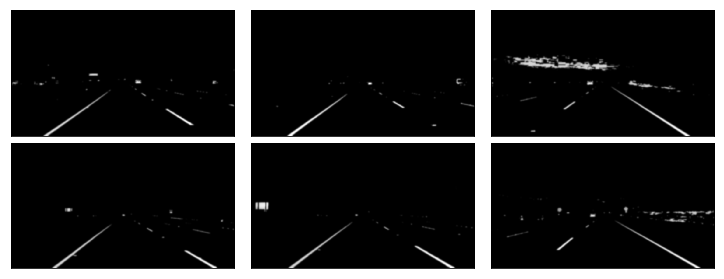

In [61]:
#Used to smooth out edges for better canny detection
#Kernel size must be positive and odd!
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

#Gaussian Blur(smooth) arguments
kernel_size = 15

smoothed_images = []
for image in gray_images:
    smoothed_images.append(gaussian_blur(image,kernel_size))

show_images(smoothed_images)

**Now we have some smooth looking edges!**
**Now we will apply Canny Edges Detection **

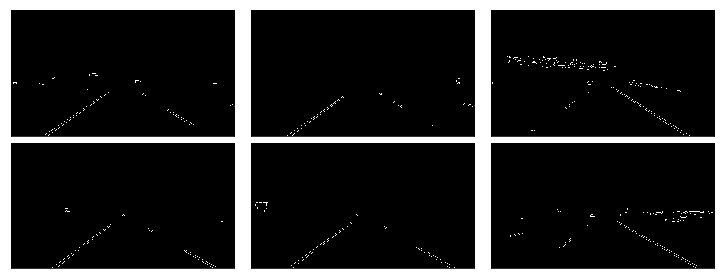

In [62]:
#Used to detect areas of rapidly chaning pixel values.  IE Edges
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

#Canny Edge Detection arguments
low_threshold = 50
high_threshold = 150

canny_edge_images = []
for image in smoothed_images:
    canny_edge_images.append(canny(image,low_threshold,high_threshold))
    
show_images(canny_edge_images)

**Now we will restrict our filtering to areas only where we are looking for lane lines. **

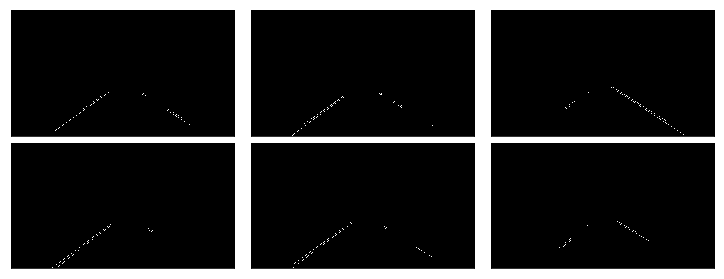

In [63]:
#this will apply color matching masks over the whole image
#then it will restrict this matching to a specific region
def region_of_interest(img, vertices):

    #Now we willl apply the region filtering.
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if (len(mask.shape) == 2):
        cv2.fillPoly(mask,vertices,255)
    else:
        cv2.fillPoly(mask,vertices,(255,)*mask.shape[2])
    
    return cv2.bitwise_and(img,mask)

#This is the 'Area of Interest' definion,  based on the camera/location these pixels will need calibration
vertices = np.array([[(135,560),(875,560),(535,325),(433,325)]],dtype=np.int32)

refined_area_images = []

for image in canny_edge_images:
    #Apply the area filtering.
    processed_area = region_of_interest(image,vertices)
    refined_area_images.append(processed_area)
    
show_images(refined_area_images)


**Next we will apply a Hough Transformation to the images **
**Once the image is in Hough coordinates we will sum all of the lines to the left and right of center**
**Once we have our lines sorted, we can average the slope on each side**
**I used a dot product to add weight to longer lines**
**After these calculations have been compelted we can computer our points into pixels**
**Then we can draw our calculated best fit lines onto our original image**

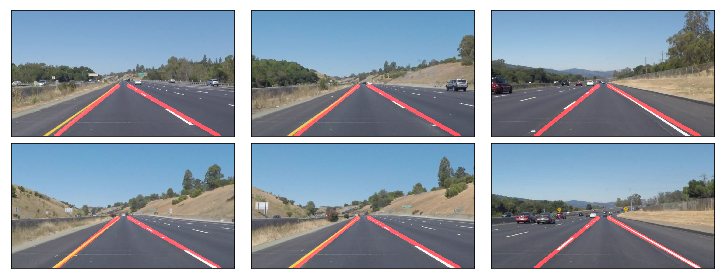

In [69]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    #Perform a hough line transformation on the image.  
    #will return a hugh line image! 
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines
def average_slope_intercept(lines):

    #create libraries for all of the lines 
    left_lines    = []
    left_weights  = []
    right_lines   = []
    right_weights = []
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #disregard slopes of zero
            if (x1 == x2):
                continue
            slope = (y2 - y1) / (x2 - x1)
            point_intercept = y1 - (slope * x1)
            line_length = np.sqrt(((y2 - y1) * (y2 - y1)) + ((x2 - x1) * (x2 - x1)))
            if (slope < 0):
                left_lines.append((slope, point_intercept))
                left_weights.append(line_length)
            else:
                right_lines.append((slope, point_intercept))
                right_weights.append(line_length)
                
    #adding extra weight for longer lane lines
    left_lane_array = (np.dot(left_weights, left_lines) / np.sum(left_weights)) if len(left_weights) > 0 else None
    right_lane_array = (np.dot(right_weights, right_lines) / np.sum(right_weights)) if len(right_weights) > 0 else None
    
    #return objects are in slope intercept form.
    return left_lane_array, right_lane_array

def line_to_pixel_convert(y1,y2,line):
    #Convert a line to pixel points
    
    if line is None:
        return None
    
    slope,intercept = line
    
    #calculating x cords for line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    #extra type casting for safety
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1,y1),(x2,y2))

def lane_lines(image,lines):
    left_lane, right_lane  = average_slope_intercept(lines)
    
    y1 = image.shape[0]
    y2 = (y1 * .6)
    
    left_line  = line_to_pixel_convert(y1,y2,left_lane)
    right_line = line_to_pixel_convert(y1,y2,right_lane)
    
    return left_line, right_line

def draw_lane_lines(image,lines,color = [255,0,0], thickness = 15):    
    #start with an clean picture the same sizde as our original image
    line_image = np.zeros_like(image)
    
    for line in lines:
        if (line is not None):
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image,1.0,line_image, 0.95, 0.0)

#Hough Transformation and draw_lane_lines arguments
rho = 1
theta = np.pi / 180
threshold = 20
min_line_length = 20
max_line_gap = 300
 

final_images = []
for image in test_images:

    #Perform hough transformation to processed image
    lines = hough_lines(processed_area, rho, theta, threshold, min_line_length, max_line_gap)
    #Process all of the individual lines and generate a best fit overlay.
    final_image = draw_lane_lines(image,lane_lines(image,lines))
    #Add processed image to new librarys
    final_images.append(final_image)
    
show_images(final_images)

 ** Here is the definition for executing the filtering process in a stream **

In [65]:
# Import everything needed to edit/save/watch video clips
QUEUE_LENGTH = 50

class LaneLineDrawer:
    def __init__(self):
        self.left_lines  = deque(maxlen = QUEUE_LENGTH)
        self.right_lines = deque(maxlen = QUEUE_LENGTH)
    
    def process(self,image):
        yellow_and_white = pull_yellow_and_white(image)
        gray   = grayscale(yellow_and_white)
        smooth = gaussian_blur(gray,kernel_size)
        edges  = canny(smooth,low_threshold, high_threshold)
        processed_area = region_of_interest(edges,vertices)
        lines = hough_lines(processed_area, rho, theta, threshold, min_line_length, max_line_gap)
        left_line, right_line = lane_lines(image,lines)
        
        def mean_line(line,lines):
            if (line is not None):
                lines.append(line)
            if (len(lines) > 0 ):
                line = np.mean(lines, axis = 0, dtype = np.int32)
                line = tuple(map(tuple,line))
            return line
        
        left_line  = mean_line(left_line, self.left_lines)
        right_line = mean_line(right_line, self.right_lines)
        
        return draw_lane_lines(image,(left_line, right_line))

In [66]:
def process_video(input_video, output_video):
    detector = LaneLineDrawer()
    clip = VideoFileClip(os.path.join('test_videos',input_video))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos',output_video),audio=False)

**Process the 3 sample videos.  I have not gotten challenge.mp4 to conform yet.**
**I think challenge will take quadratic processing and adjusting the filtering zone**

In [67]:
%time process_video("solidWhiteRight.mp4","white.mp4")

[MoviePy] >>>> Building video output_videos/white.mp4
[MoviePy] Writing video output_videos/white.mp4



100%|█████████▉| 221/222 [00:09<00:00, 22.48it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/white.mp4 

CPU times: user 23.2 s, sys: 208 ms, total: 23.4 s
Wall time: 10.8 s


In [68]:
%time process_video("solidYellowLeft.mp4","yellow.mp4")

[MoviePy] >>>> Building video output_videos/yellow.mp4
[MoviePy] Writing video output_videos/yellow.mp4



 70%|██████▉   | 476/682 [00:22<00:09, 21.53it/s]


100%|█████████▉| 681/682 [00:31<00:00, 21.80it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/yellow.mp4 

CPU times: user 1min 12s, sys: 460 ms, total: 1min 13s
Wall time: 32.1 s


<h1>Shortcomings</h1>

There are several issues that I identified right away.
- Our lane detection only draws in linearly.  
- We cannot account for gradiant on the horizontal plane.
- We hard coded are detection area to fir the orientation of this specific camera on that specific vehicle.   

<h1>Improvements</h1>

Directly related to the Shortcomings there are some improvements we could add
- We could implement quadratic estimation of lane lines to account for curves in the lane.
- We will need to be able to detect the horizon line so we can calculate changes on the horizontal axis. 
- We could implement a ratio for the detection area.  This would take the hardcoding out.